Uploaded dataset from Kaggle

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline

In [22]:
file_path = os.path.join(path, 'healthcare-dataset-stroke-data.csv')

In [23]:
df = pd.read_csv(file_path)
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [24]:
df.shape

(5110, 12)

Dropping id row as the id of the individual is not peritent to this study

In [25]:
df.drop('id', axis=1, inplace=True)

In [26]:
df['gender'].replace(['Male', 'Female','Other'], [0,1,2], inplace=True)
df['ever_married'].replace(['Yes', 'No'], [0,1],inplace=True)
df['Residence_type'].replace(['Urban','Rural'],[0,1],inplace=True)


In [27]:
df['work_type'] = df['work_type'].replace(['Private','Self-employed',
                                           'children', 'Govt_job',
                                           'Never_worked'], [0,1,2,3,4])
df['smoking_status'] = df['smoking_status'].replace(['never smoked',
                                                     'Unknown',
                                                     'formerly smoked',
                                                     'smokes'], [0,1,2,3])

In [28]:
df.head(5).T

,0,1,2,3,4
gender,0.00,1.00,0.00,1.00,1.00
age,67.00,61.00,80.00,49.00,79.00
hypertension,0.00,0.00,0.00,0.00,1.00
heart_disease,1.00,0.00,1.00,0.00,0.00
ever_married,0.00,0.00,0.00,0.00,0.00
work_type,0.00,1.00,0.00,0.00,1.00
Residence_type,0.00,1.00,1.00,0.00,1.00
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.60,NaN,32.50,34.40,24.00
smoking_status,2.00,0.00,0.00,3.00,0.00


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   int64  
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 439.3 KB


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,5110.0,0.586301,0.492941,0.00,0.000,1.000,1.00,2.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
ever_married,5110.0,0.343836,0.475034,0.00,0.000,0.000,1.00,1.00
work_type,5110.0,0.832094,1.109924,0.00,0.000,0.000,2.00,4.00
Residence_type,5110.0,0.491977,0.499985,0.00,0.000,0.000,1.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
smoking_status,5110.0,1.111742,1.071819,0.00,0.000,1.000,2.00,3.00


In [31]:
df.stroke.value_counts()


,count
stroke,
0,4861
1,249


In [32]:
df.hypertension.value_counts()


,count
hypertension,
0,4612
1,498


In [33]:
df.heart_disease.value_counts()

,count
heart_disease,
0,4834
1,276


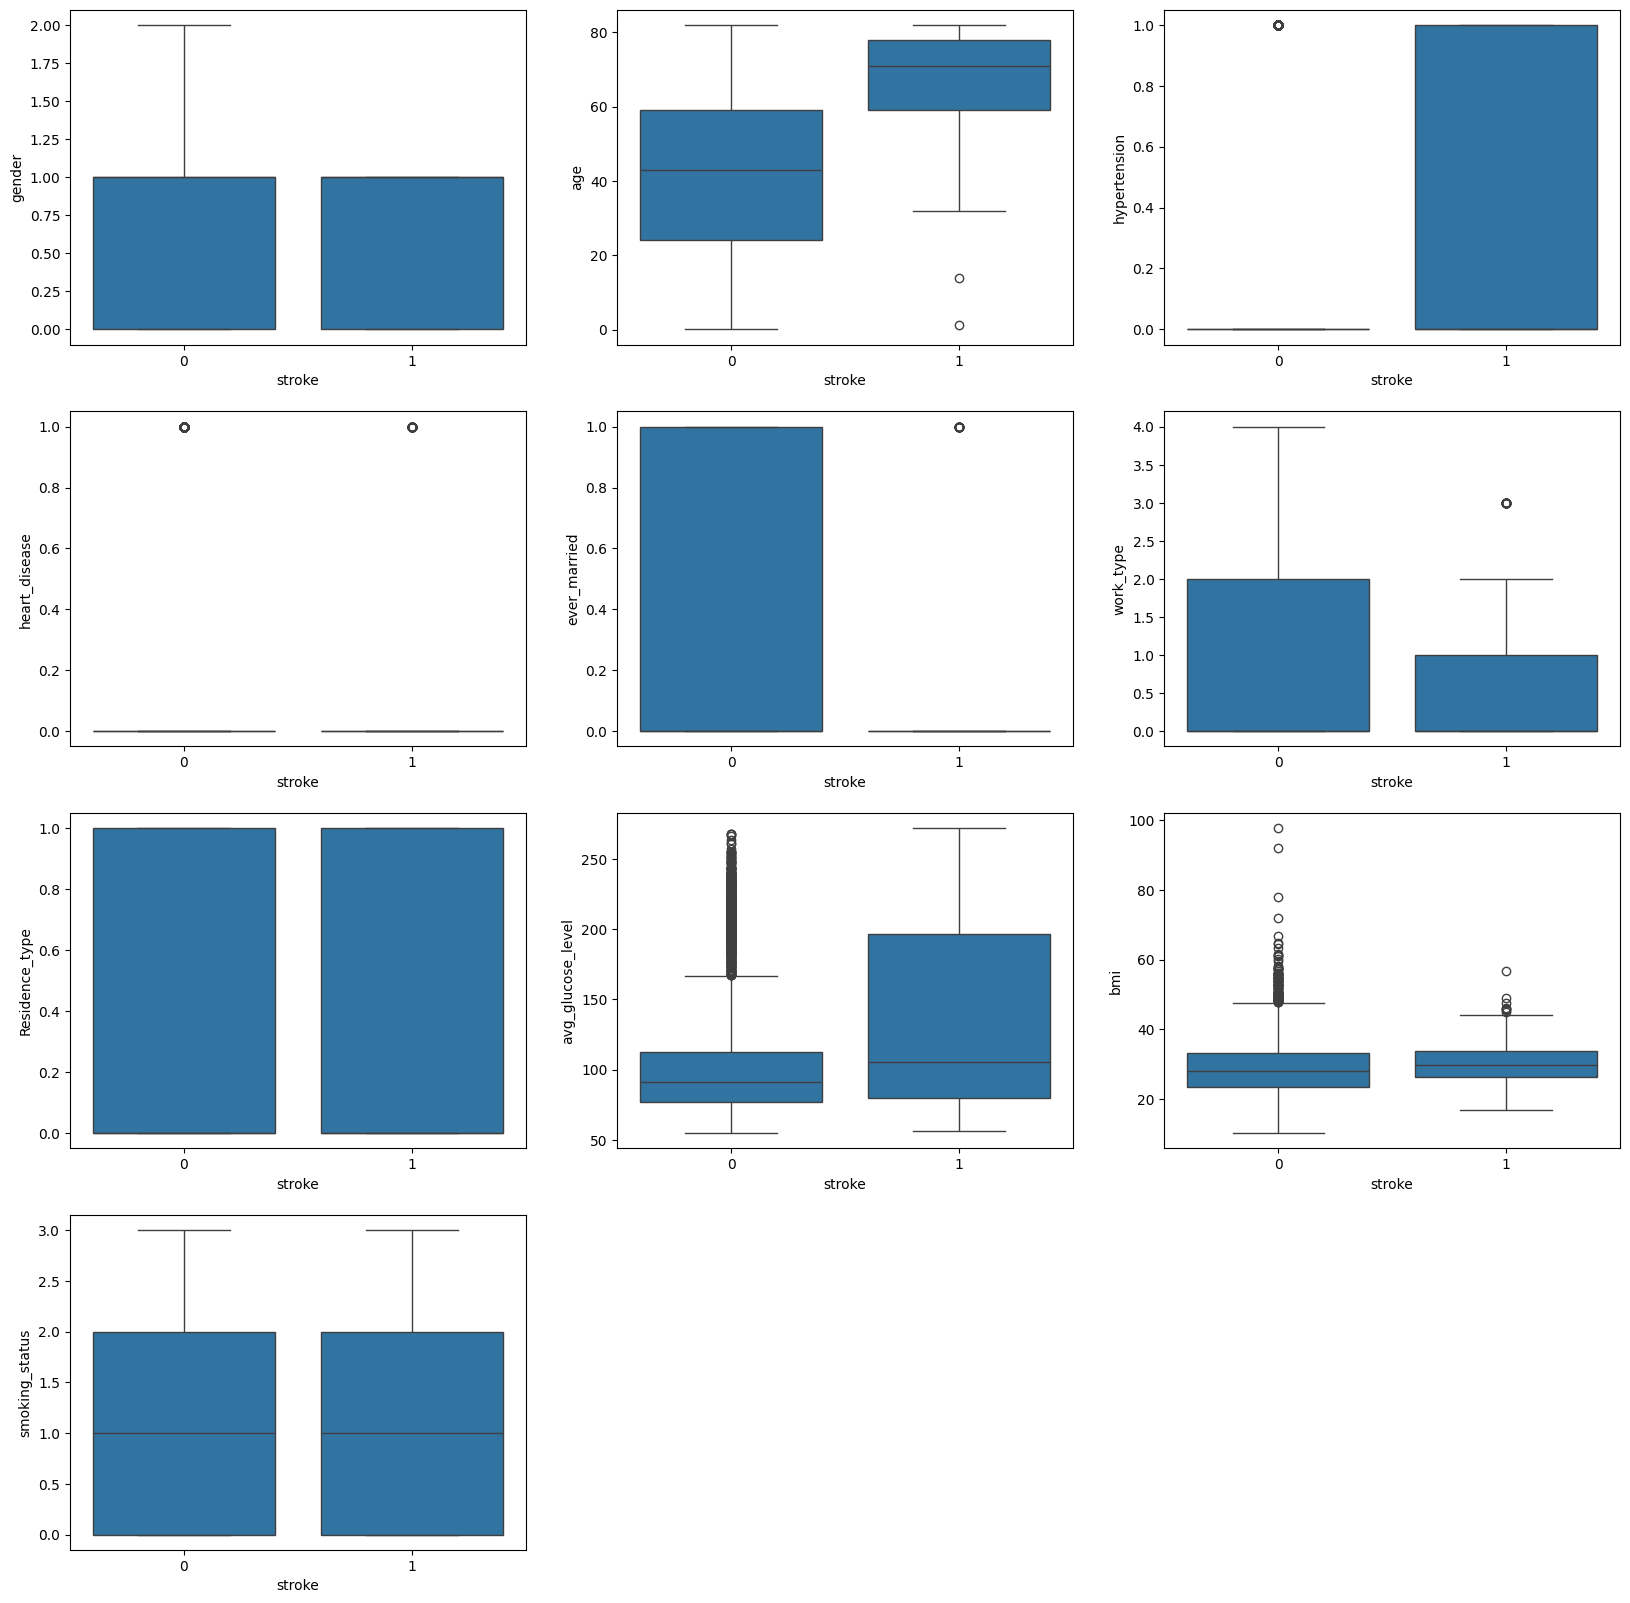

In [34]:
index = 0
plt.figure(figsize=(20,20))
num_cols = df.shape[1] -1
num_rows = (num_cols + 2) //3
for feature in df.columns:
    if feature != "stroke":
        index += 1
        plt.subplot(num_rows,3,index)
        sns.boxplot(x='stroke',y=feature,data=df)

Find the missing values next

In [35]:
miss_val = []

[miss_val.append(column) for column in df.columns if any(df[column].isnull())]

print("Columns that have missing values :")

miss_val

Columns that have missing values :


['bmi']

First looking at the BMI column

In [36]:
# function for first looking to the columns

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("--------------------------------")
    print(df[col].value_counts(dropna = False))


In [37]:
first_looking('bmi')

column name    :  bmi
--------------------------------
per_of_nulls   :  % 3.93
num_of_nulls   :  201
num_of_uniques :  418
--------------------------------
bmi
NaN     201
28.7     41
28.4     38
27.6     37
26.1     37
       ... 
47.9      1
13.0      1
46.3      1
54.1      1
14.9      1
Name: count, Length: 419, dtype: int64


Using Mode function to fill 201 missing values in BMI

In [38]:
def fill_most_freq(df, group_col, col_name):
  for group in list(df[group_col].unique()):
    cond = df[group_col]==group
    mode = list(df[cond][col_name].mode())
    if mode != []:
      df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
    else:
      df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
  print('Number of NaN : ', df[col_name].isnull().sum())
  print('------------------')
  print(df[col_name].value_counts(dropna=False))

In [39]:
fill_most_freq(df, 'gender' ,'bmi')
#check gender, or age to fill in missing values
#gender provides a larger distribution of values vs using age for filling values

Number of NaN :  0
------------------
bmi
26.7    141
23.4    133
28.7     41
28.4     38
27.7     37
       ... 
47.9      1
13.0      1
13.9      1
54.1      1
14.9      1
Name: count, Length: 418, dtype: int64


Identify and handle outliers in the data.Plot features using boxplots to visualize outliers.

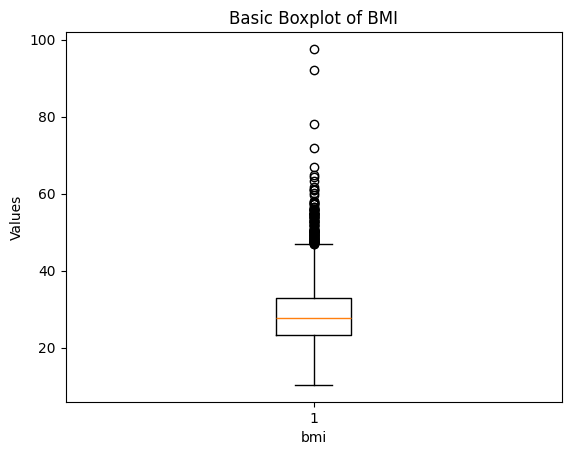

In [40]:
import sklearn

plt.boxplot(df['bmi'])
plt.title('Basic Boxplot of BMI')
plt.xlabel('bmi')
plt.ylabel('Values')

plt.show()

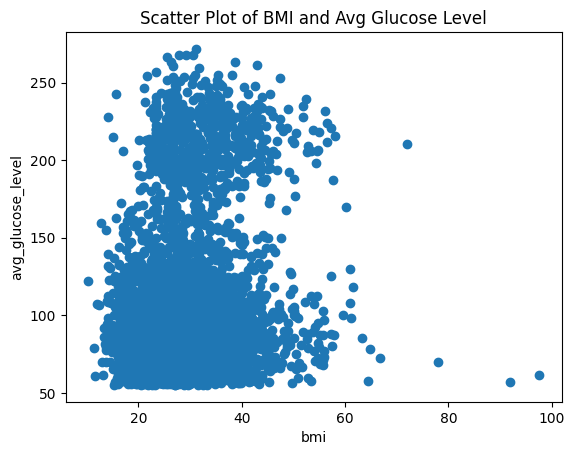

In [41]:
plt.scatter(data=df, x='bmi', y='avg_glucose_level')

plt.title('Scatter Plot of BMI and Avg Glucose Level')
plt.xlabel('bmi')
plt.ylabel('avg_glucose_level')


plt.show()

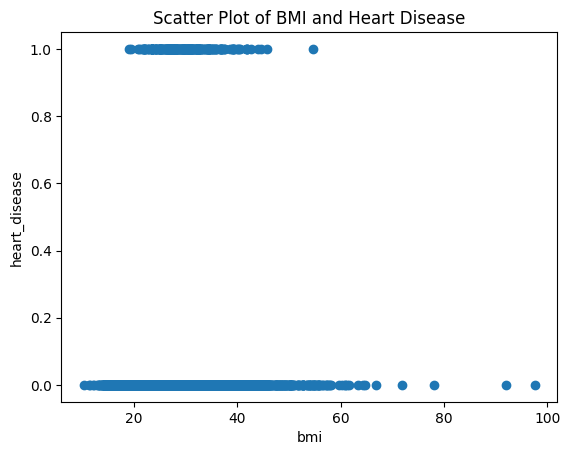

In [42]:
plt.scatter(data=df, x='bmi', y='heart_disease')

plt.title('Scatter Plot of BMI and Heart Disease')
plt.xlabel('bmi')
plt.ylabel('heart_disease')


plt.show()

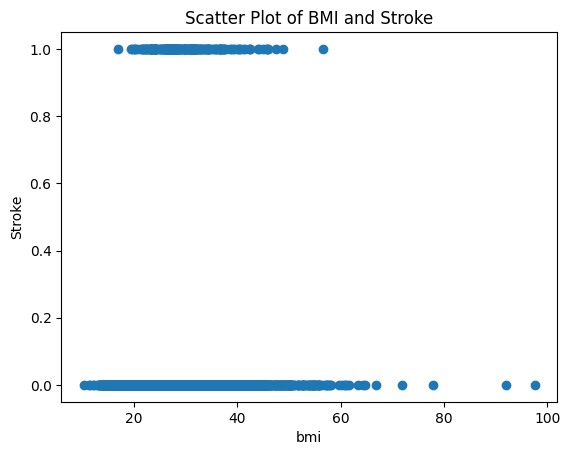

In [43]:
plt.scatter(data=df, x='bmi', y='stroke')

plt.title('Scatter Plot of BMI and Stroke')
plt.xlabel('bmi')
plt.ylabel('Stroke')


plt.show()

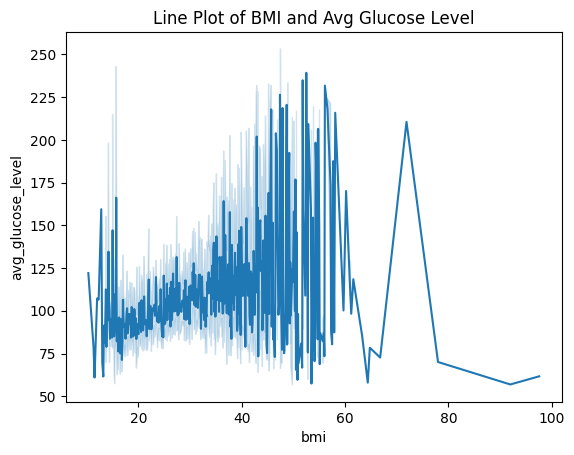

In [44]:
sns.lineplot(data=df, x='bmi', y='avg_glucose_level')
plt.title('Line Plot of BMI and Avg Glucose Level')
plt.xlabel('bmi')
plt.ylabel('avg_glucose_level')

plt.show()

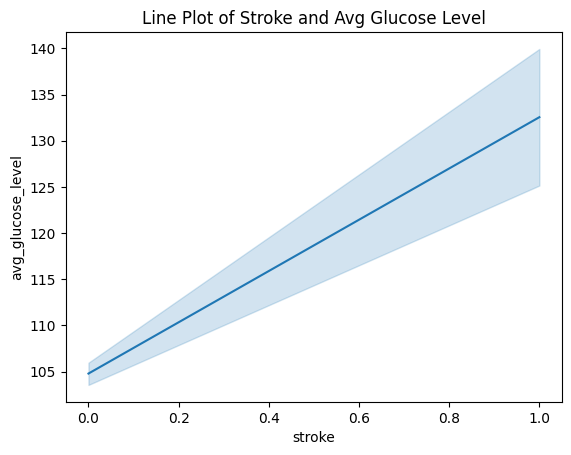

In [45]:
sns.lineplot(data=df, x='stroke', y='avg_glucose_level')
plt.title('Line Plot of Stroke and Avg Glucose Level')
plt.xlabel('stroke')
plt.ylabel('avg_glucose_level')

plt.show()

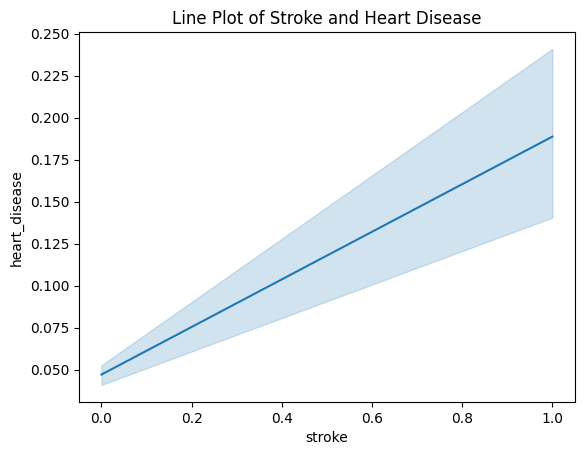

In [46]:
sns.lineplot(data=df, x='stroke', y='heart_disease')
plt.title('Line Plot of Stroke and Heart Disease')
plt.xlabel('stroke')
plt.ylabel('heart_disease')

plt.show()

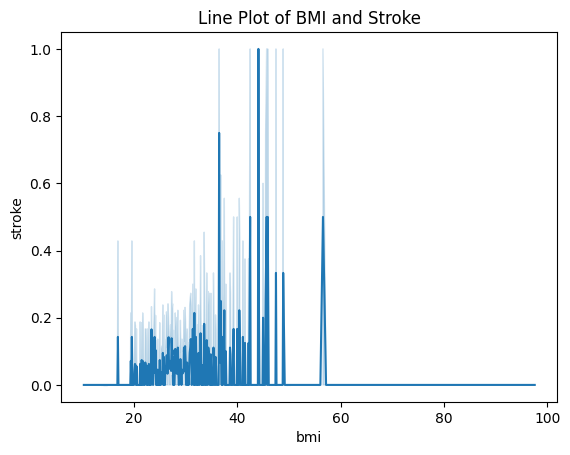

In [47]:
sns.lineplot(data=df, x='bmi', y='stroke')
plt.title('Line Plot of BMI and Stroke')
plt.xlabel('bmi')
plt.ylabel('stroke')

plt.show()

By using the above data visulization tools we can assess that BMI and Age have a direct correlation.

SCALING the data

In [48]:
X=df.drop(["stroke"], axis=1)
y=df["stroke"]

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                     random_state=42)

In [51]:
scaler = StandardScaler()


Modeling

In [52]:
def eval_metric(model, X_train, y_train, X_test, y_test):
  y_pred_train = model.predict(X_train)
  y_pred = model.predict(X_test)

  print('Test_Set')
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print('------------------------------------')
  print('Train_Set')
  print(confusion_matrix(y_train, y_train))
  print(classification_report(y_train, y_pred_train))

In [53]:
log_model = LogisticRegression(class_weight='balanced')

In [54]:
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [55]:
print('Log Model')
eval_metric(log_model, X_train, y_train, X_test, y_test)

Log Model
Test_Set
[[711 249]
 [ 11  51]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       960
           1       0.17      0.82      0.28        62

    accuracy                           0.75      1022
   macro avg       0.58      0.78      0.56      1022
weighted avg       0.94      0.75      0.81      1022

------------------------------------
Train_Set
[[3901    0]
 [   0  187]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3901
           1       0.13      0.82      0.22       187

    accuracy                           0.73      4088
   macro avg       0.56      0.77      0.53      4088
weighted avg       0.95      0.73      0.81      4088



In [56]:
scoring = {'precision-neg': make_scorer(precision_score,average='binary',),
           'recall-neg': make_scorer(recall_score,average='binary',),
           'f1-neg': make_scorer(f1_score,average='binary')}

In [57]:
scores = cross_validate(log_model, X_train, y_train, scoring = scoring, cv=10)
df_scores = pd.DataFrame(scores, index = range(1,11))
df_scores.mean()[2:]

,0
test_precision-neg,0.126252
test_recall-neg,0.801462
test_f1-neg,0.217989


In [58]:
y_pred=log_model.predict(X_train)

In [59]:
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [60]:
y_pred_train=log_model.predict(X_train)

In [61]:
y_pred_train

array([1, 0, 0, ..., 0, 1, 0])

In [62]:
#test_data = pd.concat([X_test, y_test],axis=1)
#test_data['pred'] = y_pred
#test_data['pred_proba'] = y_pred
#test_data.sample(5)

Model Performance on Classification

SVM modelling

In [63]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

svc = SVC(C=0.01)
svc.fit(X_train, y_train)
#svm_model = SVR(kernel='linear')
#svm_model.fit(X_train, y_train)
#eval_metric(svm_model, X_train, y_train, X_test, y_test)


SVC(C=0.01)

In [64]:
print('SVC Model')
eval_metric(svc, X_train, y_pred_train, X_test,y_test)

SVC Model
Test_Set
[[960   0]
 [ 62   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022

------------------------------------
Train_Set
[[2882    0]
 [   0 1206]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      2882
           1       0.00      0.00      0.00      1206

    accuracy                           0.70      4088
   macro avg       0.35      0.50      0.41      4088
weighted avg       0.50      0.70      0.58      4088



XGB model

In [65]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(random_state=101, class_weight='balanced')
xgb_model.fit(X_train, y_train)
eval_metric(xgb_model, X_train, y_train, X_test, y_test)

Test_Set
[[947  13]
 [ 57   5]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       960
           1       0.28      0.08      0.12        62

    accuracy                           0.93      1022
   macro avg       0.61      0.53      0.54      1022
weighted avg       0.90      0.93      0.91      1022

------------------------------------
Train_Set
[[3901    0]
 [   0  187]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3901
           1       1.00      0.98      0.99       187

    accuracy                           1.00      4088
   macro avg       1.00      0.99      1.00      4088
weighted avg       1.00      1.00      1.00      4088



In [66]:
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [67]:
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.00))

Accuracy: 93.15%


Light GBM model

In [68]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test,reference=train_data)

In [69]:
params = {
    "objective": "binary",
    "boosting_type": "rf",
    "num_leaves": 5, "force_row_wise": True,
    "learning_rate": 0.5,
    "metric": "binary_logloss",
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8
}

In [70]:
num_round = 500
bst = lgb.train(params, train_data, num_round, valid_sets = [test_data])

[LightGBM] [Info] Number of positive: 187, number of negative: 3901
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045744 -> initscore=-3.037880
[LightGBM] [Info] Start training from score -3.037880


In [71]:
y_pred = bst.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1score = f1_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1score: {f1score:.4f}')


Accuracy: 0.9344
Precision: 0.4138
Recall: 0.1935
F1score: 0.2637


In [72]:
lgb_report = classification_report(y_test, y_pred_binary)
print(lgb_report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       960
           1       0.41      0.19      0.26        62

    accuracy                           0.93      1022
   macro avg       0.68      0.59      0.61      1022
weighted avg       0.92      0.93      0.92      1022



KNN using the Regressor due to continuous data

In [73]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [74]:
print('KNN Model')
eval_metric(knn, X_train, y_train, X_test, y_test)

KNN Model
Test_Set
[[957   3]
 [ 61   1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.25      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.60      0.51      0.50      1022
weighted avg       0.90      0.94      0.91      1022

------------------------------------
Train_Set
[[3901    0]
 [   0  187]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3901
           1       0.57      0.02      0.04       187

    accuracy                           0.95      4088
   macro avg       0.76      0.51      0.51      4088
weighted avg       0.94      0.95      0.93      4088



In [75]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train, y_train, scoring =scoring, cv=10)
df_scores = pd.DataFrame(scores, index = range(1,11))
df_scores.mean()[:]

,0
fit_time,0.006728
score_time,0.037443
test_precision-neg,0.033333
test_recall-neg,0.005263
test_f1-neg,0.009091


Recall Curve for KNN

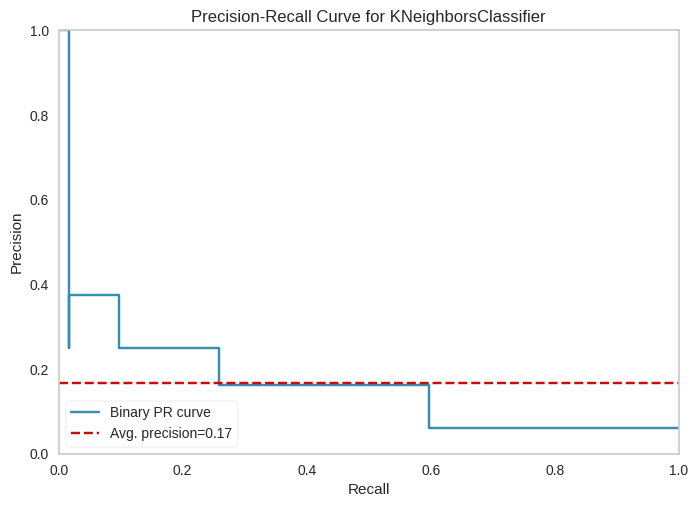

<Axes: title={'center': 'Precision-Recall Curve for KNeighborsClassifier'}, xlabel='Recall', ylabel='Precision'>

In [76]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap='Set1'
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

ROC curve using KNN model

In [78]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc, roc_curve, average_precision_score, precision_recall_curve

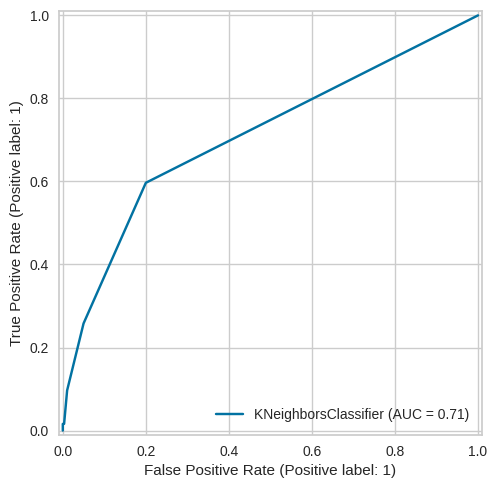

In [79]:
model.fit(X_train,y_train)
RocCurveDisplay.from_estimator(model, X_test, y_test)

ROC Curve using Log model

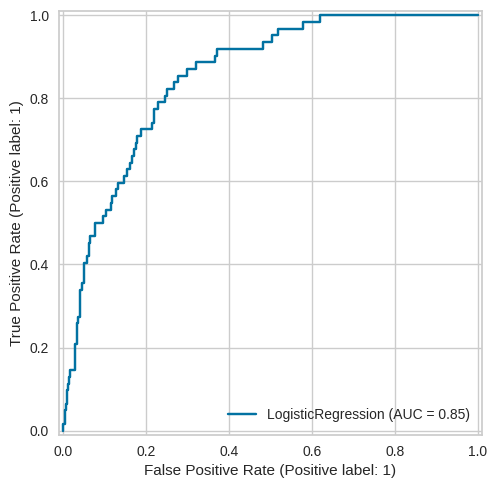

In [80]:
RocCurveDisplay.from_estimator(log_model, X_test, y_test)

RANDOM FOREST

In [81]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=101,class_weight='balanced')
                           #class_weight='balanced')
rf_model.fit(X_train, y_train)
eval_metric(rf_model,X_train, y_train, X_test, y_test)

Test_Set
[[960   0]
 [ 62   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022

------------------------------------
Train_Set
[[3901    0]
 [   0  187]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3901
           1       1.00      1.00      1.00       187

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



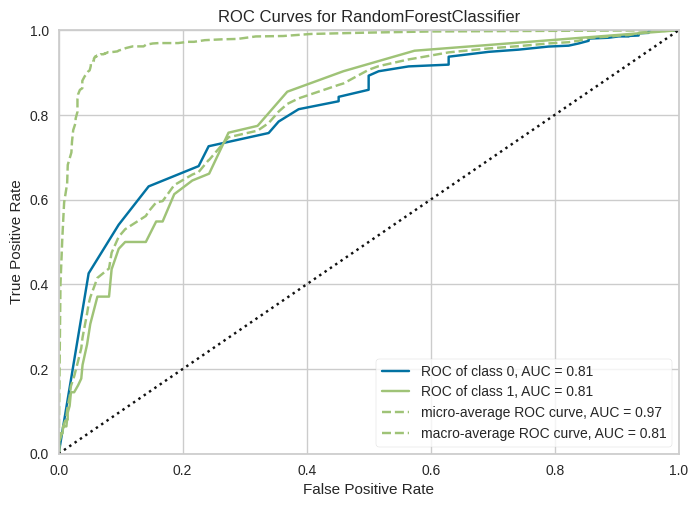

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [82]:
from yellowbrick.classifier import ROCAUC

rf_model_2 = RandomForestClassifier()
visualizer = ROCAUC(rf_model_2)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

Run SMOTE for imbalanced always use class_weight = 'balanced'

SMOTE Increases the number of minority class samples through interpolation, improving the generalization ability of classifiers.

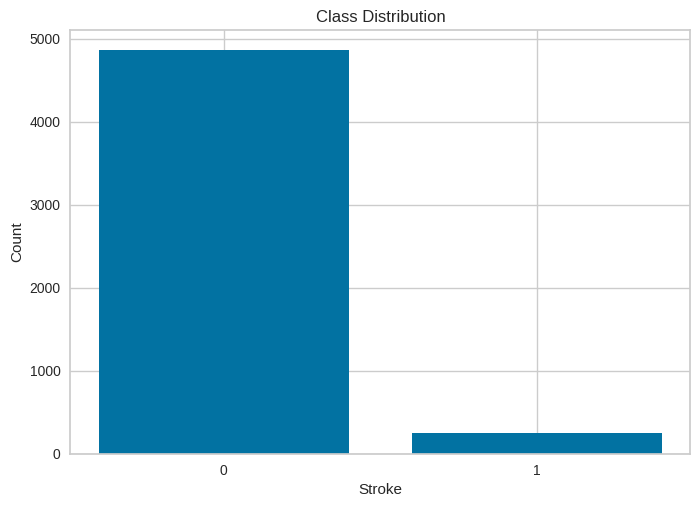

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

x = df.drop(['stroke'],axis=1)
y = df['stroke']

count_class = y.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(range(len(count_class.index)), count_class.index)
plt.show()

In [84]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC

smote = SMOTE(sampling_strategy='minority')
x,y = smote.fit_resample(x,y)
y.value_counts()

,count
stroke,
1,4861
0,4861


SMOTE-NC....not to be used in every model

SMOTE Nominal Continuous Handles mixed data types without distorting the categorical feature space.

In [85]:
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1,0.9],n_informative=3, n_redundant=1,
                           flip_y=0, n_features=5, n_clusters_per_class=1,
                           n_samples=100, random_state=10)

print('Original Class Distribution:')
print('Class 0:', np.bincount(y)[0], 'Class 1:', np.bincount(y)[1])

categorical_features = [0,3]

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

X_resampled, y_resampled = smote_nc.fit_resample(X,y)

print('\nResampled Class Distribution:')
print('Class 0:',np.bincount(y_resampled)[0], 'Class 1:',
      np.bincount(y_resampled)[1])

Original Class Distribution:
Class 0: 10 Class 1: 90

Resampled Class Distribution:
Class 0: 90 Class 1: 90


Comparing Models


In [86]:
models = {
    "Random Forest": rf_model,
    "KNN": knn,
    "LightGBM": bst,  # Assuming bst is your LightGBM model
    "XGBoost": xgb_model,
    "SVC": svc,
    "Logistic Regression": log_model
}

results = []

for model_name, model in models.items():
  if model_name == 'LightGBM':
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1score = f1_score(y_test, y_pred_binary)
  else:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
  results.append([model_name,accuracy, precision, recall, f1])

results_df = pd.DataFrame(results, columns=['Model', "Accuracy", "Precision",
                                            "Recall", "F1-Score"])

print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.939335   0.000000  0.000000  0.000000
1                  KNN  0.937378   0.250000  0.016129  0.030303
2             LightGBM  0.934442   0.413793  0.193548  0.030303
3              XGBoost  0.931507   0.277778  0.080645  0.125000
4                  SVC  0.939335   0.000000  0.000000  0.000000
5  Logistic Regression  0.745597   0.170000  0.822581  0.281768


In [87]:
result_test = results_df.iloc[1::2]

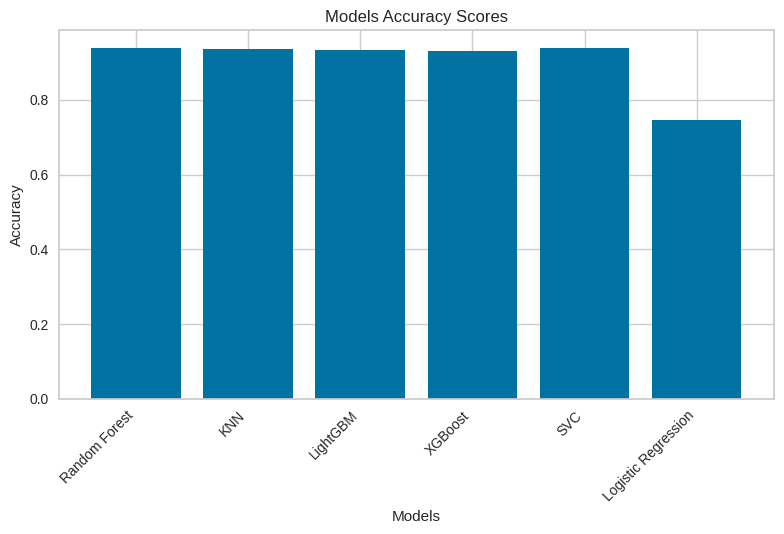

In [88]:
Models = list(models.keys())
Accuracy = results_df['Accuracy'].tolist()


plt.bar(Models, Accuracy)
plt.title('Models Accuracy Scores')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [89]:
knn_last = KNeighborsClassifier(n_neighbors = 5,
               weights = 'uniform',
               algorithm = 'auto',
               leaf_size = 30,
               p = 2,
               metric = 'minkowski',
               metric_params = None,
               n_jobs=None)

knn_last.fit(X_train, y_train)


KNeighborsClassifier()

In [90]:
eval_metric(knn_last,X_train, y_train, X_test, y_test)

Test_Set
[[955   5]
 [ 61   1]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.17      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.55      0.51      0.50      1022
weighted avg       0.89      0.94      0.91      1022

------------------------------------
Train_Set
[[3901    0]
 [   0  187]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3901
           1       0.70      0.09      0.15       187

    accuracy                           0.96      4088
   macro avg       0.83      0.54      0.57      4088
weighted avg       0.95      0.96      0.94      4088



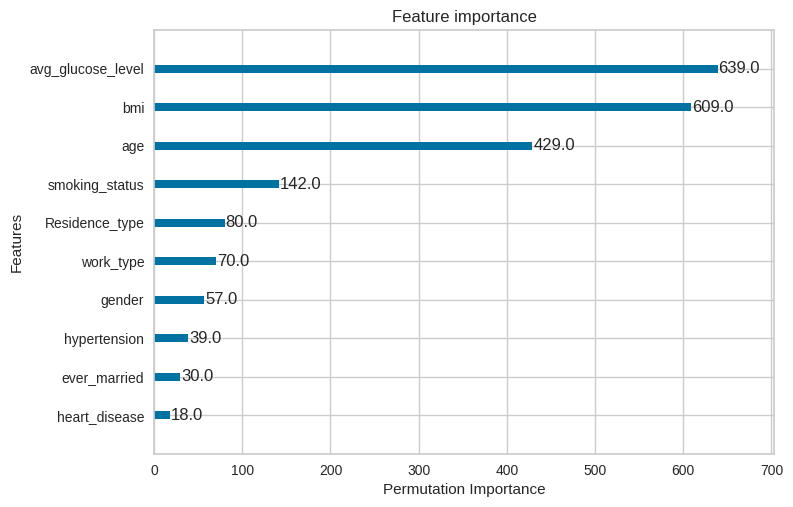

In [91]:
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

plot_importance(xgb_model, max_num_features=10)

perm_importance = permutation_importance(knn_last, X_test, y_test, n_repeats=30,
                                         random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()


FINAL MODEL

In [92]:
import pickle

In [93]:
final_model = knn_last
final_model.fit(X_train, y_train)

KNeighborsClassifier()

In [94]:
pickle.dump(final_model, open('final_model.pkl', 'wb'))

In [97]:
pickle.dump(scaler,open('scaler.pkl', 'wb'))